In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# Reproduce Yuanzhi's Results
Architecture is reLU((I+W)x)



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class Net(nn.Module):

    def __init__(self, d):
        super(Net, self).__init__()
        self.fc = nn.Linear(d, d)
        
    def forward(self, x):
        y = F.relu(self.fc(x) + x)
        return torch.sum(y)





In [0]:
class TeacherNet(object):
  def __init__(self, d):
    self.W1 = torch.rand(d,d)
  def compute(self, x):
    return torch.sum(F.relu(torch.mv(self.W1, x) + x))
  def getWeights(self):
    return self.W1


We generate the examples that we want to train on here

In [0]:
import numpy as np
d = 5
net = Net(d)
teacher = TeacherNet(d)
inputs = []
trueOutputs = []
for i in range(100000):
  # x is sampled N 0,1
  x = np.random.multivariate_normal(np.zeros(d), np.identity(d))
  x = torch.from_numpy(x)
  x = x.float()
  y = teacher.compute(x)
  inputs.append(x)
  trueOutputs.append(y)

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, featureList, outputList):
    self.featureList = featureList
    self.outputList = outputList
    assert len(featureList) == len(outputList)
  def __getitem__(self,idx):
    return self.featureList[idx], self.outputList[idx]
  def __len__(self):
    return len(self.featureList)

Put the teaching data into a dataloader

In [0]:
import torch.utils.data as utils
dataset = MyDataset(inputs, trueOutputs)
trainloader = utils.DataLoader(dataset, batch_size = 200,
                               shuffle = True, num_workers = 2)

Nesterov momentum 

In [0]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)


In [0]:
iterations = 0
distances = []
iterationNumbers = []
num_batches = 250
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      features, values = data
      
      # zero the parameter gradients
      optimizer.zero_grad()
      
      # forward + backward + optimize
      outputlist = []
      for feature in features:
        outputlist.append(net(feature))
      outputs = torch.stack([j for j in outputlist])
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      
      if i % num_batches == (num_batches - 1):
        # find the distance between parameters
        params = list(net.parameters())
        studentW1 = params[0]
        teacherW1 = teacher.getWeights()
        distance = np.linalg.norm(studentW1.data.numpy() - teacherW1.data.numpy()) 
        studentW1Norm = np.linalg.norm(studentW1.data.numpy())
        distances.append(distance)
        iterationNumbers.append(iterations)
        print('[%d, %5d] loss: %.3f, distance: %.4f, norm1: %.3f' %
            (epoch + 1, i + 1, running_loss/num_batches, distance, 
            studentW1Norm))
        running_loss = 0.0
      iterations += 1

print('Finished Training')

In [36]:

len(iterationNumbers)

200

In [37]:
len(distances)

200

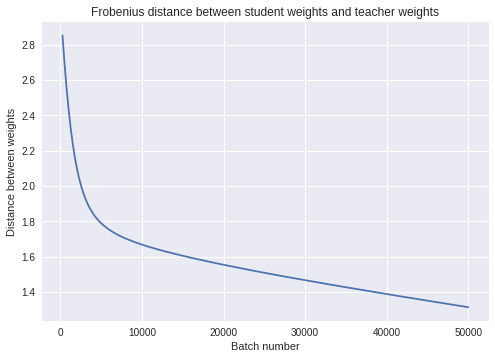

In [39]:
import matplotlib.pylab as plt
plt.plot(iterationNumbers, distances)
plt.title("Frobenius distance between student weights and teacher weights")
plt.xlabel("Batch number")
plt.ylabel("Distance between weights")
plt.show()

# Try it on a true ResNet block
Architecture is W2Relu(W1x) + x

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as utils
import torch.optim as optim

class Net(nn.Module):

    def __init__(self, d):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(d, d, bias = False)
        self.fc2 = nn.Linear(d, d, bias = False)
        
    def forward(self, x):
        y = self.fc1(x)
        y = F.relu(x)
        y = self.fc2(x)
        x = y + x
        return torch.sum(x)

class TeacherNet(object):
  def __init__(self, d):
    self.W1 = torch.randn(d,d)
    self.W2 = torch.randn(d,d)
  def compute(self, x):
    return torch.sum(torch.mv(self.W2, F.relu(torch.mv(self.W1, x))) + x)
  def getWeights(self):
    return (self.W1, self.W2)

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, featureList, outputList):
    self.featureList = featureList
    self.outputList = outputList
    assert len(featureList) == len(outputList)
  def __getitem__(self,idx):
    return self.featureList[idx], self.outputList[idx]
  def __len__(self):
    return len(self.featureList)

In [0]:
d = 1
net = Net(d)
teacher = TeacherNet(d)
import numpy as np

inputs = []
trueOutputs = []
for i in range(100000):
  # x is sampled N 0,1
  x = np.random.multivariate_normal(np.zeros(d), np.identity(d))
  x = torch.from_numpy(x)
  x = x.float()
  y = teacher.compute(x)
  inputs.append(x)
  trueOutputs.append(y)
  
dataset = MyDataset(inputs, trueOutputs)
trainloader = utils.DataLoader(dataset, batch_size = 200,
                               shuffle = True, num_workers = 2)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)

In [0]:
iterations = 0
distances = []
iterationNumbers = []
num_batches = 250
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      features, values = data
      
      # zero the parameter gradients
      optimizer.zero_grad()
      
      # forward + backward + optimize
      outputlist = []
      for feature in features:
        outputlist.append(net(feature))
      outputs = torch.stack([j for j in outputlist])
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      
      if i % num_batches == (num_batches - 1):
        # find the distance between parameters
        params = list(net.parameters())
        studentW1 = params[0]
        studentW2 = params[1]
        (teacherW1, teacherW2) = teacher.getWeights()
        distance = np.linalg.norm(studentW1.data.numpy() - teacherW1.data.numpy()) + np.linalg.norm(studentW2.data.numpy() - teacherW2.data.numpy())
        studentW1Norm = np.linalg.norm(studentW1.data.numpy())
        studentW2Norm = np.linalg.norm(studentW2.data.numpy())
        distances.append(distance)
        iterationNumbers.append(iterations)
        print('[%d, %5d] loss: %.3f, distance: %.4f, norm1: %.3f, norm2: %.3f' %
            (epoch + 1, i + 1, running_loss/num_batches, distance, 
            studentW1Norm, studentW2Norm))
        running_loss = 0.0
      iterations += 1

print('Finished Training')


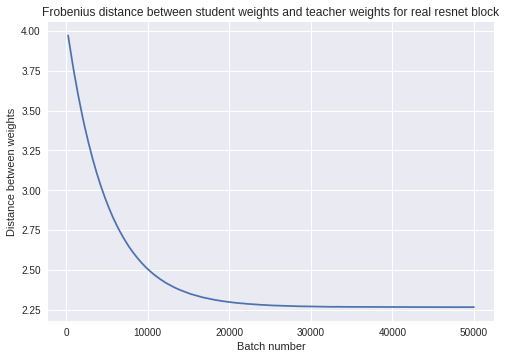

In [65]:
import matplotlib.pylab as plt
plt.plot(iterationNumbers, distances)
plt.title("Frobenius distance between student weights and teacher weights for real resnet block")
plt.xlabel("Batch number")
plt.ylabel("Distance between weights")
plt.show()

# Try Yuanzhi's architecture on a ResNet teacher network, use its weight to initialize

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as utils
import torch.optim as optim

class Net(nn.Module):

    def __init__(self, d):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(d, d, bias = False)
        self.fc2 = nn.Linear(d, d, bias = False)
        
    def forward(self, x):
        y = self.fc1(x)
        y = F.relu(x)
        y = self.fc2(x)
        x = y + x
        return torch.sum(x)

class yuanzhiNet(nn.Module):

    def __init__(self, d):
        super(yuanzhiNet, self).__init__()
        self.fc = nn.Linear(d, d, bias = False)
        
    def forward(self, x):
        y = F.relu(self.fc(x) + x)
        return torch.sum(y)



class TeacherNet(object):
  def __init__(self, d):
    self.W1 = torch.randn(d,d)
    self.W2 = torch.randn(d,d)
  def compute(self, x):
    return torch.sum(torch.mv(self.W2, F.relu(torch.mv(self.W1, x))) + x)
  def getWeights(self):
    return (self.W1, self.W2)

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, featureList, outputList):
    self.featureList = featureList
    self.outputList = outputList
    assert len(featureList) == len(outputList)
  def __getitem__(self,idx):
    return self.featureList[idx], self.outputList[idx]
  def __len__(self):
    return len(self.featureList)

In [0]:
d = 1
net = Net(d)
yuanzhinet = yuanzhiNet(d)
teacher = TeacherNet(d)
import numpy as np

inputs = []
trueOutputs = []
for i in range(100000):
  # x is sampled N 0,1
  x = np.random.multivariate_normal(np.zeros(d), np.identity(d))
  x = torch.from_numpy(x)
  x = x.float()
  y = teacher.compute(x)
  inputs.append(x)
  trueOutputs.append(y)
  
dataset = MyDataset(inputs, trueOutputs)
trainloader = utils.DataLoader(dataset, batch_size = 200,
                               shuffle = True, num_workers = 2)
criterion = nn.MSELoss()
optimizer = optim.SGD(yuanzhinet.parameters(), lr=0.0001)

In [0]:
iterations = 0
losses = []
iterationNumbers = []
num_batches = 250
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      features, values = data
      
      # zero the parameter gradients
      optimizer.zero_grad()
      
      # forward + backward + optimize
      outputlist = []
      for feature in features:
        outputlist.append(yuanzhinet(feature))
      outputs = torch.stack([j for j in outputlist])
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      
      if i % num_batches == (num_batches - 1):
        # find the distance between parameters
        iterationNumbers.append(iterations)
        losses.append(running_loss/num_batches)
        print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss/num_batches))
        running_loss = 0.0
      iterations += 1

print('Finished Training')

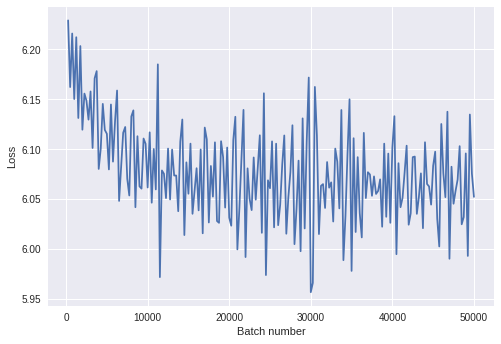

In [14]:
import matplotlib.pylab as plt
plt.plot(iterationNumbers, losses)
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.show()

In [18]:
teacher.getWeights()

(tensor([[-0.9384]]), tensor([[-2.6461]]))

In [0]:
yuanzhiparam = list(yuanzhinet.parameters())[0].data

In [0]:
yuanzhiparam =  np.asscalar(yuanzhiparam)

In [23]:
net = Net(d)



[Parameter containing:
 tensor([[-0.8312]], requires_grad=True), Parameter containing:
 tensor([[-0.9125]], requires_grad=True)]

In [0]:
#nn.init.constant(net.named_parameters()[0], yuanzhiparam)
for name, param in net.named_parameters():
  nn.init.constant_(param, yuanzhiparam)

In [46]:
list(net.parameters())

[Parameter containing:
 tensor([[0.0035]], requires_grad=True), Parameter containing:
 tensor([[0.0035]], requires_grad=True)]

In [48]:
optimizer = optim.SGD(net.parameters(), lr=0.0001)
iterations = 0
distances = []
iterationNumbers = []
num_batches = 250
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      features, values = data
      
      # zero the parameter gradients
      optimizer.zero_grad()
      
      # forward + backward + optimize
      outputlist = []
      for feature in features:
        outputlist.append(net(feature))
      outputs = torch.stack([j for j in outputlist])
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      
      if i % num_batches == (num_batches - 1):
        # find the distance between parameters
        params = list(net.parameters())
        studentW1 = params[0]
        studentW2 = params[1]
        (teacherW1, teacherW2) = teacher.getWeights()
        distance = np.linalg.norm(studentW1.data.numpy() - teacherW1.data.numpy()) + np.linalg.norm(studentW2.data.numpy() - teacherW2.data.numpy())
        studentW1Norm = np.linalg.norm(studentW1.data.numpy())
        studentW2Norm = np.linalg.norm(studentW2.data.numpy())
        distances.append(distance)
        iterationNumbers.append(iterations)
        print('[%d, %5d] loss: %.3f, distance: %.4f, norm1: %.3f, norm2: %.3f' %
            (epoch + 1, i + 1, running_loss/num_batches, distance, 
            studentW1Norm, studentW2Norm))
        running_loss = 0.0
      iterations += 1

print('Finished Training')

[1,   250] loss: 2.850, distance: 3.7090, norm1: 0.004, norm2: 0.121
[1,   500] loss: 2.746, distance: 3.7638, norm1: 0.004, norm2: 0.176
[2,   250] loss: 2.619, distance: 3.8157, norm1: 0.004, norm2: 0.228
[2,   500] loss: 2.521, distance: 3.8652, norm1: 0.004, norm2: 0.277
[3,   250] loss: 2.445, distance: 3.9126, norm1: 0.004, norm2: 0.325
[3,   500] loss: 2.322, distance: 3.9569, norm1: 0.004, norm2: 0.369
[4,   250] loss: 2.259, distance: 3.9992, norm1: 0.004, norm2: 0.411
[4,   500] loss: 2.203, distance: 4.0399, norm1: 0.004, norm2: 0.452
[5,   250] loss: 2.142, distance: 4.0786, norm1: 0.004, norm2: 0.491
[5,   500] loss: 2.070, distance: 4.1149, norm1: 0.004, norm2: 0.527
[6,   250] loss: 2.033, distance: 4.1497, norm1: 0.004, norm2: 0.562
[6,   500] loss: 1.975, distance: 4.1828, norm1: 0.004, norm2: 0.595
[7,   250] loss: 1.953, distance: 4.2147, norm1: 0.004, norm2: 0.627
[7,   500] loss: 1.888, distance: 4.2443, norm1: 0.004, norm2: 0.656
[8,   250] loss: 1.879, distance: 

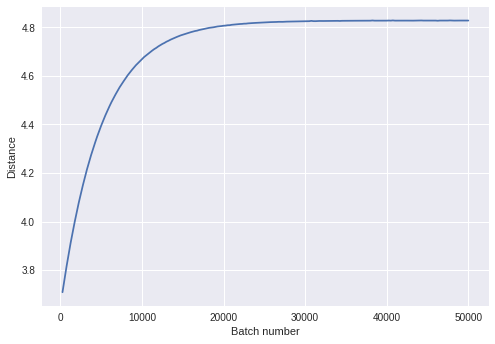

In [49]:
import matplotlib.pylab as plt
plt.plot(iterationNumbers, distances)
plt.xlabel("Batch number")
plt.ylabel("Distance")
plt.show()